In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from pandas import DataFrame, Panel4D, read_hdf
from glob import glob
from datetime import datetime
import time
import matplotlib
import gps

In [ ]:
files = glob("/home/greg/Documents/Summer Research/rinex files/mah*")

svn = 23

convertL1ToMeters = 3.0E8/(154.0*10.23E6)
convertL2ToMeters = 3.0E8/(120.0*10.23E6)
f2f1Factor = 1.545727
convertMetersToTEC = 6.158

dat = {}

t=time.time()
for file in files:  
    d = gps.rinexobs(file)
    dat[file.split('/')[-1]] = d[:,svn,:,:]
data = Panel4D(dat)
print("Seconds to read all files {0:.2f}".format(time.time()-t))
data.to_hdf('svn23.h5','data',format='table')


/home/greg/Documents/Summer Research/rinex files/mah62800.15o is a RINEX 2.11 file, 31649.899 kB.
31.92 seconds for _block2df
17.37 seconds for panel assignments
finished in 52.88 seconds
/home/greg/Documents/Summer Research/rinex files/mah32800.15o is a RINEX 2.11 file, 38072.718 kB.


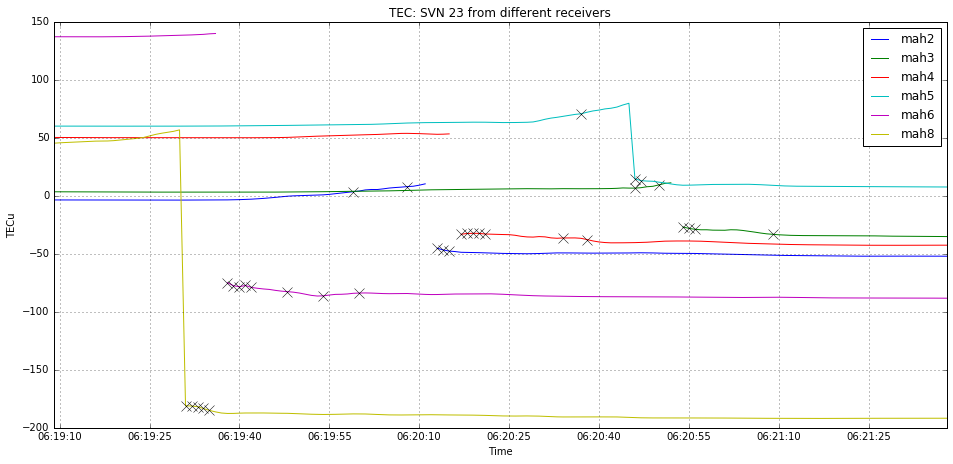

In [3]:
data = read_hdf('svn23.h5','data')
fig = plt.figure(figsize=(16,16))
ax1 = plt.subplot(211)
fmt = DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)
ax1.autoscale_view()
plt.title('TEC: SVN 23 from different receivers')
plt.xlabel('Time')
plt.ylabel('TECu')


convertL1ToMeters = 3.0E8/(154.0*10.23E6)
convertL2ToMeters = 3.0E8/(120.0*10.23E6)
f2f1Factor = 1.545727
convertMetersToTEC = 6.158

for site in data.labels:
    
    lli = data[site,:,['L1','L2','C1','P2'],'lli']
    lli[np.isnan(lli)]=0
    lli=lli.astype(int)
    llimask = np.logical_or.reduce(lli%2)
        
    diffRange = data[site,:,'P2','data'] - data[site,:,'C1','data']
    diffRange = diffRange * convertMetersToTEC * f2f1Factor
    phase = f2f1Factor*(data[site,:,'L1','data']*convertL1ToMeters - data[site,:,'L2','data']*convertL2ToMeters)
    phase = phase * convertMetersToTEC
    
    avg = np.average((phase-diffRange)[np.logical_not(np.isnan(phase-diffRange))])
    TEC = phase - avg
    
    if(site!='mah92800.15o' and site!='mah72800.15o'): 
        plt.plot(TEC[1100:1250],label=site[:4])
        plt.plot(TEC[1100:1250][llimask[1100:1250]],'kx',markersize=10,label='')
plt.legend()
plt.grid()
plt.show()

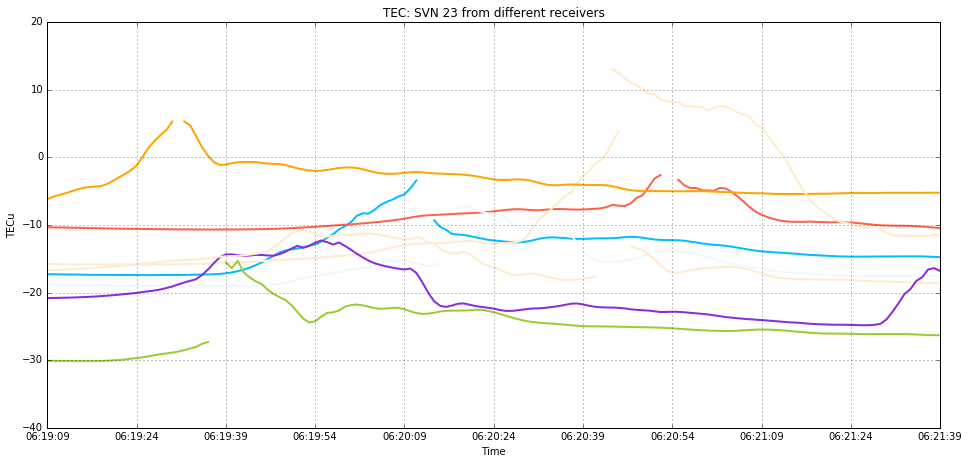

In [6]:
import random
f1 = 1575.42E6 
f2 = 1227.6E6 

fig = plt.figure(figsize=(16,16))
ax1 = plt.subplot(211).xaxis.set_major_formatter(fmt)
plt.title('TEC: SVN 23 from different receivers')
plt.xlabel('Time')
plt.ylabel('TECu')
colors = [a for a in matplotlib.colors.cnames]

for site in data.labels[:]:

    nans_in_a_row = 0
    checkindex=2
    lowers=[]
    uppers=[]
    inarc=False
    check = 2.85E9*(data[site,:,'L1','data']/f1-data[site,:,'L2','data']/f2)
    color=random.choice(colors)

    while(checkindex<len(check)):
        if(not np.isnan(check[data.items[checkindex]]) and 
           abs(check[data.items[checkindex]]-check[data.items[checkindex-1]])<10):
            if not inarc:
                inarc=True
                lowers.append(checkindex)            
        else:
            if inarc:
                inarc=False
                uppers.append(checkindex)
        checkindex+=1
    uppers.append(checkindex)
    
    for i in range(len(lowers)):
        phtec = 2.85E9*(data[site,data.items[lowers[i]:uppers[i]],'L1','data']/f1
                       -data[site,data.items[lowers[i]:uppers[i]],'L2','data']/f2)
        prtec = 2.85E9*(data[site,data.items[lowers[i]:uppers[i]],'P2','data']/3.0E8
                       -data[site,data.items[lowers[i]:uppers[i]],'C1','data']/3.0E8)
        b = np.average((phtec-prtec)[~np.isnan(phtec-prtec)])
        plt.plot(phtec-b,c=color,linewidth=2)     
    
plt.xlim([data.items[1100],data.items[1250]])
plt.grid()
plt.show()